### Importing libraries

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
import sys
import numpy as np
import nltk
import os
import re
_wnl = nltk.WordNetLemmatizer()
from tqdm import tqdm
import scipy
from csv import DictReader
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
# sklearn dependencies
from sklearn import feature_extraction
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from collections import defaultdict


# Function for reading the dataset
class DataSet():
    def __init__(self, name="train", path="/content/drive/My Drive/fnc-1"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"
        
        self.stances = self.read(stances)
       
        articles = self.read(bodies)
       
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])
        
        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))

    

    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Functions to form various features 

In [9]:
# Feature Functions(taken from baseline and added cosine similarity)
def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
  # if not os.path.isfile(feature_file):
    feats = feat_fn(headlines, bodies)
    np.save(feature_file, feats)
    return np.load(feature_file)

def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)


def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features

def cosine_similarity_h(headlines, bodies):
	vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')#, max_features=1024)

	cos_sim_features = []
	for i in range(0, len(bodies)):
		body_headline = []
		body_headline.append(bodies[i])
		body_headline.append(headlines[i])
		tfidf = vectorizer.fit_transform(body_headline)

		cosine_similarity = (tfidf * tfidf.T).A
		cos_sim_features.append(cosine_similarity[0][1])

	
	cos_sim_array = np.array(cos_sim_features) 

	return cos_sim_array

def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X


### Functions to generate splits

In [11]:

# Functions to generate splits

def generate_hold_out_split (dataset, training = 0.8, base_dir="/content/drive/My Drive/fnc-1"):
    r = random.Random()
    r.seed(1489215)

    article_ids = list(dataset.articles.keys())  # get a list of article ids
    r.shuffle(article_ids)  # and shuffle that list


    training_ids = article_ids[:int(training * len(article_ids))]
    hold_out_ids = article_ids[int(training * len(article_ids)):]

    # write the split body ids out to files for future use
    with open(base_dir+ "/"+ "training_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in training_ids]))

    with open(base_dir+ "/"+ "hold_out_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in hold_out_ids]))



def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
           ids.append(int(line))
        return ids


def kfold_split(dataset, training = 0.8, n_folds = 10, base_dir="/content/drive/My Drive/fnc-1"):
    if not (os.path.exists(base_dir+ "/"+ "training_ids.txt")
            and os.path.exists(base_dir+ "/"+ "hold_out_ids.txt")):
        generate_hold_out_split(dataset,training,base_dir)

    training_ids = read_ids("training_ids.txt", base_dir)
    hold_out_ids = read_ids("hold_out_ids.txt", base_dir)

    folds = []
    for k in range(n_folds):
        folds.append(training_ids[int(k*len(training_ids)/n_folds):int((k+1)*len(training_ids)/n_folds)])

    return folds,hold_out_ids


def get_stances_for_folds(dataset,folds,hold_out):
    stances_folds = defaultdict(list)
    stances_hold_out = []
    for stance in dataset.stances:
        if stance['Body ID'] in hold_out:
            stances_hold_out.append(stance)
        else:
            fold_id = 0
            for fold in folds:
                if stance['Body ID'] in fold:
                    stances_folds[fold_id].append(stance)
                fold_id += 1

    return stances_folds,stances_hold_out


### Functions to generate the score

In [13]:
# Score functions
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

# function for printing confusion Matrix
def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score




### Generating Features

In [14]:


def generate_features(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "hand."+name+".npy")
    X_cosine=gen_or_load_feats(cosine_similarity_h,h,b,"cosine."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap,X_cosine]
    X = preprocessing.scale(X)
    return X,y
    



    
#Load the training dataset and generate folds
d = DataSet()
folds,hold_out = kfold_split(d,n_folds=10)
fold_stances, hold_out_stances = get_stances_for_folds(d,folds,hold_out)

# Load the competition dataset
competition_dataset = DataSet("competition_test")
X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")
    
  
Xs = dict()
ys = dict()

# Load/Precompute all features now
X_holdout,y_holdout = generate_features(hold_out_stances,d,"holdout")
for fold in fold_stances:
    Xs[fold],ys[fold] = generate_features(fold_stances[fold],d,str(fold))


best_score = 0
best_fold = None

    





    
# print(predicted)




Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset


0it [00:00, ?it/s]

Total stances: 25413
Total bodies: 904


25413it [01:28, 287.48it/s]
25413it [00:05, 4983.83it/s]
25413it [01:27, 289.48it/s]
25413it [01:33, 273.24it/s]
9622it [00:34, 276.91it/s]
9622it [00:01, 5044.07it/s]
9622it [00:34, 275.82it/s]
9622it [00:38, 252.33it/s]
4124it [00:14, 275.27it/s]
4124it [00:00, 5178.30it/s]
4124it [00:15, 271.80it/s]
4124it [00:16, 253.90it/s]
4663it [00:17, 268.28it/s]
4663it [00:00, 5222.57it/s]
4663it [00:17, 266.55it/s]
4663it [00:18, 247.28it/s]
3783it [00:11, 315.85it/s]
3783it [00:00, 5128.81it/s]
3783it [00:12, 311.53it/s]
3783it [00:13, 289.90it/s]
3388it [00:12, 262.67it/s]
3388it [00:00, 5046.68it/s]
3388it [00:12, 261.59it/s]
3388it [00:13, 244.38it/s]
3644it [00:13, 272.96it/s]
3644it [00:00, 5084.44it/s]
3644it [00:13, 268.19it/s]
3644it [00:14, 254.82it/s]
4644it [00:16, 282.02it/s]
4644it [00:00, 5191.23it/s]
4644it [00:16, 274.94it/s]
4644it [00:18, 257.32it/s]
3848it [00:14, 266.29it/s]
3848it [00:00, 5200.73it/s]
3848it [00:14, 259.63it/s]
3848it [00:15, 243.55it/s]
4273it [00:14, 

In [15]:
# Classifier for each fold
for fold in fold_stances:
    ids = list(range(len(folds)))
    del ids[fold]

    X_train = np.vstack(tuple([Xs[i] for i in ids]))
    y_train = np.hstack(tuple([ys[i] for i in ids]))

    X_test = Xs[fold]
    y_test = ys[fold]
            
            
    gradientboosting = GradientBoostingClassifier( n_estimators=100, random_state=42,verbose=True,subsample=0.9)
    gradientboosting.fit(X_train, y_train)
            
              
    predicted = [LABELS[int(a)] for a in gradientboosting.predict(X_test)]   
          
            
    actual = [LABELS[int(a)] for a in y_test]

    fold_score, _ = score_submission(actual, predicted)
    max_fold_score, _ = score_submission(actual, actual)

    score = fold_score/max_fold_score

    print("Score for fold "+ str(fold) + " was - " + str(score))
    if score > best_score:
        best_score = score
        best_fold = gradientboosting



#Run on Holdout set and report the final score on the holdout set
predicted = [LABELS[int(a)] for a in best_fold.predict(X_holdout)]
    
    
actual = [LABELS[int(a)] for a in y_holdout]

    
report_score(actual,predicted)
print("")
print("")
#Run on competition dataset
   
predicted = [LABELS[int(a)] for a in best_fold.predict(X_competition)]
actual = [LABELS[int(a)] for a in y_competition]
    
    
a=report_score(actual,predicted)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       22112.6978         418.3374           48.44s
         2       19761.8563         258.3209           47.93s
         3       17847.9261         197.7168           47.21s
         4       16565.5343         148.5658           46.81s
         5       15434.0585         118.7304           46.25s
         6       14514.4496          98.5159           46.10s
         7       13764.1054          80.3755           45.86s
         8       13181.4071          66.8602           45.40s
         9       12638.2679          54.6753           44.96s
        10       12171.3476          45.0315           44.39s
        20       10100.7488           9.1875           38.80s
        30        9528.2547           0.9025           33.96s
        40        9123.3210           1.0200           29.66s
        50        8939.5114           0.3791           24.86s
        60        8851.2218          -0.1665           19.86s
       

In [23]:

data = {'Iterations':  [1, 2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100],
        'Loss': [22194.4070,19779.9174,17959.4557,16603.5056,15511.8594, 14602.8131,13910.4883,13208.1117,12633.8252,12271.9072,10183.7280,9568.5745,9206.9733,9001.6804,8825.1934,
                8716.2480, 8578.4964,8487.2534,8403.3948],
        
        }
gb = pd.DataFrame (data, columns = ['Iterations','Loss'])

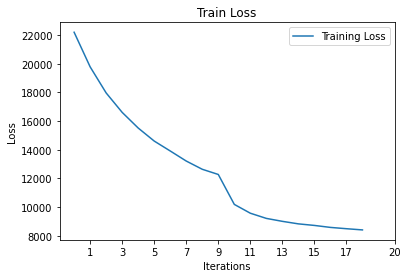

In [24]:
# Plotting train loss vs Iterations
import matplotlib.pyplot as plt

plt.plot(gb['Loss'])
plt.xlabel('Iterations')
plt.xticks([1,3,5,7,9,11,13,15,17,20])
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend(['Training Loss'])
plt.savefig('Gradient_loss.png')
plt.show()

In [25]:
comp_test=pd.read_csv('/content/drive/My Drive/fnc-1/competition_test_stances.csv')

In [26]:
#General Loss
from sklearn.metrics import accuracy_score
accuracy_score(comp_test['Stance'],predicted)

0.8668004564592925

In [27]:
#Generating answers.csv
body_id = []
headlines = []
stances = np.copy(np.array(predicted))

for i in range(len(competition_dataset.stances)):
    body_id.append(competition_dataset.stances[i]['Body ID'])
    headlines.append(competition_dataset.stances[i]['Headline'])
test_data = pd.DataFrame(columns=['Headline', 'Body ID', 'Stance'])
test_data['Headline'] = headlines
test_data['Body ID'] = body_id
test_data['Stance'] = stances
print(test_data.head())

test_data.to_csv('Gradient_Boosting_cosine_sim_tuned.csv', index=False, encoding='utf-8')


                                            Headline  Body ID     Stance
0  Ferguson riots: Pregnant woman loses eye after...     2008  unrelated
1  Crazy Conservatives Are Sure a Gitmo Detainee ...     1550  unrelated
2  A Russian Guy Says His Justin Bieber Ringtone ...        2  unrelated
3  Zombie Cat: Buried Kitty Believed Dead, Meows ...     1793  unrelated
4  Argentina's President Adopts Boy to End Werewo...       37  unrelated


In [28]:
#Calculating f1 score of individual stances type(Competition set)
from sklearn.metrics import f1_score

def calculate_f1scores(y_true, y_predicted):
    
    f1_macro = f1_score(y_true, y_predicted, average='macro')
    f1_classwise = f1_score(y_true, y_predicted, average=None, labels=["agree", "disagree", "discuss", "unrelated"])

    result = "F1 macro: {:.3f}".format(f1_macro * 100) + "% \n"
    result += "F1 agree: {:.3f}".format(f1_classwise[0] * 100) + "% \n"
    result += "F1 disagree: {:.3f}".format(f1_classwise[1] * 100) + "% \n"
    result += "F1 discuss: {:.3f}".format(f1_classwise[2] * 100) + "% \n"
    result += "F1 unrelated: {:.3f}".format(f1_classwise[3] * 100) + "% \n"
    return result
print(calculate_f1scores(predicted,actual))

F1 macro: 45.893% 
F1 agree: 14.236% 
F1 disagree: 0.284% 
F1 discuss: 72.128% 
F1 unrelated: 96.926% 



In [29]:
# calculating precision,recall,f1-score,support for Competition set
from sklearn.metrics import classification_report

eval_report = classification_report(predicted,actual)
print('Test report', eval_report)

Test report               precision    recall  f1-score   support

       agree       0.09      0.42      0.14       387
    disagree       0.00      0.14      0.00         7
     discuss       0.86      0.62      0.72      6156
   unrelated       0.98      0.96      0.97     18863

    accuracy                           0.87     25413
   macro avg       0.48      0.54      0.46     25413
weighted avg       0.94      0.87      0.90     25413

